# OIC-Grid: Clustering multiagente

**Asignatura:** Sistemas Multiagente 
**Autor:** Juan Esteban Rincón Marín
**Objetivo:** Evaluar un algoritmo de clustering inspirado en el proceso de opsonización del sistema inmune sobre datasets clásicos, utilizando métricas externas e internas estándar. Se ha dado con el nombre tan original de **Opsozation-Inspired Clustering**, abreviado en **OIC**

Este notebook contiene **toda la implementación y evaluación**, organizada por secciones temáticas para facilitar su lectura y evaluación.

## Datasets seleccionados

Para la validación experimental del algoritmo de clustering propuesto se han seleccionado los datasets **Iris** y **Wine**, ambos ampliamente utilizados como benchmarks en la literatura científica sobre clustering y aprendizaje no supervisado.

### Iris
El dataset Iris contiene 150 instancias descritas por 4 variables numéricas continuas, distribuidas en 3 clases reales. Su tamaño reducido y estructura bien estudiada lo convierten en un conjunto de datos idóneo para validar el comportamiento inicial de algoritmos de clustering y facilitar la interpretación de los resultados.

### Wine
El dataset Wine está compuesto por 178 instancias con 13 variables numéricas, también organizadas en 3 clases reales. Presenta una mayor dimensionalidad y complejidad que Iris, lo que permite evaluar la robustez del algoritmo frente a espacios de características más ricos.

Ambos datasets incluyen etiquetas reales que **no se utilizan durante el proceso de clustering**, sino exclusivamente para la evaluación posterior mediante métricas externas, siguiendo el enfoque estándar en aprendizaje no supervisado.

## Métricas de evaluación

La evaluación del rendimiento del algoritmo se realiza combinando métricas externas e internas, con el objetivo de analizar tanto la correspondencia con las clases reales como la calidad estructural de los clusters obtenidos.

### Métricas externas

**Adjusted Rand Index (ARI)**  
Se utiliza como métrica principal para medir la similitud entre el clustering obtenido y las etiquetas reales. El índice está ajustado por azar, lo que permite una comparación robusta entre diferentes configuraciones y evita sesgos derivados de asignaciones aleatorias.

**Normalized Mutual Information (NMI)**  
Se emplea como métrica principal complementaria al ARI. Evalúa la cantidad de información compartida entre la partición obtenida y las clases reales, y es especialmente adecuada para comparar particiones independientemente de la permutación de etiquetas.

### Métricas internas

**Silhouette Score**  
Se utiliza como métrica interna de apoyo para evaluar la cohesión interna de los clusters y su separación relativa, sin hacer uso de información externa. Permite analizar la calidad geométrica de la partición resultante.

**Davies–Bouldin Index**  
Se emplea como métrica interna complementaria al Silhouette Score. Mide la relación entre la dispersión intra-cluster y la separación inter-cluster, siendo valores más bajos indicativos de una mejor estructura de clustering.

La combinación de métricas externas e internas permite una evaluación más completa del algoritmo, evitando depender de un único criterio y alineándose con las prácticas habituales en la literatura científica.

# 1. Imports y configuración global

In [72]:
# IMPORTS

import numpy as np
import pandas as pd

from dataclasses import dataclass
from typing import List, Tuple, Optional
from itertools import product
from copy import deepcopy

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn.datasets import load_iris, load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)

from sklearn.cluster import KMeans

# CONSTANTES GLOBALES

UNASSIGNED = -1


# 2. Implementación mínima del algoritmo OIC con su calculo de metricas online y la aplicación de metricas internas y externas
En esta sección se incluyen la definición de funciones de ayuda, dataclasses y la definición de la clase del algoritmo con su función fit().
Posteriormente se definen funciones para calcular metricas offline y metricas online del algortimo, asi como la funcion fit_predict().

## 2.1. Utilidades geométricas y operaciones sobre el grid
En esta sección se agrupan funciones auxiliares **independientes del algoritmo**, relacionadas con:
- distancias
- vecindarios
- movimiento en grid
- búsqueda de celdas libres

No contienen lógica de clustering.


In [73]:
def chebyshev_distance(p1: Tuple[int, int], p2: Tuple[int, int]) -> int:
    """Calcula la distancia de Chebyshev entre dos posiciones."""
    # Distancia L inf para vecindarios tipo Moore.
    return max(abs(p1[0] - p2[0]), abs(p1[1] - p2[1]))


def get_neighborhood(center: Tuple[int, int], radius: int, grid) -> List[Tuple[int, int]]:
    """Devuelve las celdas válidas dentro de un radio Chebyshev."""
    # Explora el cuadrado (2r+1)x(2r+1) alrededor del centro.
    cx, cy = center
    cells: List[Tuple[int, int]] = []
    for dx in range(-radius, radius + 1):
        for dy in range(-radius, radius + 1):
            pos = (cx + dx, cy + dy)
            if grid.is_valid(pos):
                cells.append(pos)
    return cells


def ordered_objects_in_cells(
    cells: List[Tuple[int, int]],
    grid,
    objects: List
) -> List:
    """Obtiene los objetos presentes en las celdas en orden determinista."""
    # Orden de lectura por filas: (y, x).
    sorted_cells = sorted(cells, key=lambda pos: (pos[1], pos[0]))

    obj_by_id = {obj.object_id: obj for obj in objects}
    found: List = []

    for cell in sorted_cells:
        obj_id = grid.get_cell(cell)
        if obj_id is not None and obj_id in obj_by_id:
            found.append(obj_by_id[obj_id])

    return found


def random_walk_step_8dir(
    pos: Tuple[int, int],
    grid,
    rng: np.random.Generator
) -> Tuple[int, int]:
    """Da un paso aleatorio válido en 8 direcciones."""
    # Movimiento exploratorio sin objetivo.
    directions = [(-1, -1), (-1, 0), (-1, 1),
                  (0, -1),           (0, 1),
                  (1, -1),  (1, 0),  (1, 1)]

    valid_moves: List[Tuple[int, int]] = []
    x, y = pos
    for dx, dy in directions:
        npos = (x + dx, y + dy)
        if grid.is_valid(npos):
            valid_moves.append(npos)

    if not valid_moves:
        return pos

    return valid_moves[int(rng.integers(0, len(valid_moves)))]


def greedy_step_minimize_dinf(
    current: Tuple[int, int],
    target: Tuple[int, int],
    grid
) -> Tuple[int, int]:
    """Da un paso que minimiza la distancia de Chebyshev al objetivo."""
    # Movimiento reactivo hacia el objetivo más cercano.
    directions = [(-1, -1), (-1, 0), (-1, 1),
                  (0, -1),           (0, 1),
                  (1, -1),  (1, 0),  (1, 1)]

    best_pos = current
    best_dist = chebyshev_distance(current, target)

    cx, cy = current
    for dx, dy in directions:
        npos = (cx + dx, cy + dy)
        if grid.is_valid(npos):
            d = chebyshev_distance(npos, target)
            if d < best_dist:
                best_dist = d
                best_pos = npos

    return best_pos


def nearest_free_cell_by_increasing_radius(
    center: Tuple[int, int],
    grid,
    max_radius: int = 50
) -> Optional[Tuple[int, int]]:
    """Busca la celda libre más cercana ampliando el radio progresivamente."""
    # Búsqueda radial determinista alrededor del centro.
    for r in range(0, max_radius + 1):
        cells = get_neighborhood(center, r, grid)
        cells.sort(key=lambda p: (chebyshev_distance(p, center), p[1], p[0]))

        for cell in cells:
            if grid.is_free(cell):
                return cell

    return None


## 2.2. Entidades del sistema multiagente
Aquí se definen las estructuras de datos que representan el estado del sistema:
- Objetos a clasificar
- Balizas (beacons)
- Agentes (marcadores y transportadores)
- Grid y estado global

No se ejecuta el algoritmo en esta sección.


In [74]:
@dataclass
class Beacon:
    """Baliza que representa un clúster y su prototipo."""
    cluster_id: int
    grid_pos: Tuple[int, int]
    prototype: np.ndarray
    count: int = 1

    def update_prototype(self, new_object: np.ndarray) -> None:
        """Actualiza el prototipo usando media incremental."""
        self.count += 1
        self.prototype += (new_object - self.prototype) / self.count


@dataclass
class GridObject:
    """Objeto de datos situado en el grid."""
    object_id: int
    features: np.ndarray
    grid_pos: Tuple[int, int]
    label: int = 0  # 0 significa sin asignar
    discarded: bool = False # Esto evita que se vuelva a recoger


class Grid:
    """Grid 2D que almacena la ocupación por celda."""
    
    def __init__(self, width: int, height: int):
        self.width = width
        self.height = height
        # occupancy[y][x] contiene object_id o None
        self.occupancy: List[List[Optional[int]]] = [
            [None for _ in range(width)] for _ in range(height)
        ]

    def is_valid(self, pos: Tuple[int, int]) -> bool:
        """Comprueba si una posición está dentro del grid."""
        x, y = pos
        return 0 <= x < self.width and 0 <= y < self.height

    def is_free(self, pos: Tuple[int, int]) -> bool:
        """Indica si una celda válida está libre."""
        if not self.is_valid(pos):
            return False
        x, y = pos
        return self.occupancy[y][x] is None

    def set_cell(self, pos: Tuple[int, int], obj_id: Optional[int]) -> None:
        """Ocupa o libera una celda del grid."""
        x, y = pos
        self.occupancy[y][x] = obj_id

    def get_cell(self, pos: Tuple[int, int]) -> Optional[int]:
        """Devuelve el object_id almacenado en una celda."""
        x, y = pos
        return self.occupancy[y][x]


@dataclass
class MarkerAgent:
    """Agente que crea balizas y etiqueta objetos."""
    agent_id: int
    grid_pos: Tuple[int, int]


@dataclass
class TransporterAgent:
    """Agente que transporta objetos entre celdas."""
    agent_id: int
    grid_pos: Tuple[int, int]
    carrying: Optional[int] = None

## 2.3. Algoritmo OIC-Grid
Esta sección implementa el núcleo del algoritmo de clustering multiagente.
Incluye la dinámica de los agentes, la creación y uso de balizas y la lógica
de asignación de etiquetas.

No incluye métricas ni evaluación experimental.


In [75]:
class OICGrid:
    """Clustering inspirado en opsonización sobre un grid 2D."""

    def __init__(
        self,
        grid_scale: float = 4.0,
        object_radius: int = 1,
        beacon_radius: int = 5,
        local_beacon_cap: int = 3,
        n_marker_agents: int = 5,
        n_transporter_agents: int = 5,
        seed_object_placement: int = 42,
        seed_agent_walk: int = 43,
        seed_tau_calculator: int = 44,
        tau_percentile: int = 15,
        tau_sample_ratio: float = 1.0
    ):
        """Configura el grid, los radios, la capacidad local, los agentes y las semillas."""
        self.lambda_grid = grid_scale
        self.r_obj = object_radius
        self.r_beacon = beacon_radius
        self.k_local = local_beacon_cap

        self.n_markers = n_marker_agents
        self.n_transporters = n_transporter_agents

        self.rng_place = np.random.default_rng(seed_object_placement)
        self.rng_walk = np.random.default_rng(seed_agent_walk)
        self.rng_tau = np.random.default_rng(seed_tau_calculator)

        self.objects: List[GridObject] = []
        self.beacons: List[Beacon] = []
        self.grid: Optional[Grid] = None
        self.markers: List[MarkerAgent] = []
        self.transporters: List[TransporterAgent] = []
        self.tau: float = 0.0
        self.tau_percentile: int = tau_percentile
        self.tau_sample_ratio: float = tau_sample_ratio

        self.states = []

    def normalize(self, X: np.ndarray) -> np.ndarray:
        """Normaliza las features con z-score."""
        return StandardScaler().fit_transform(X)

    def compute_tau(
        self,
        X: np.ndarray,
        percentile: float = 15.0,
        sample_ratio: float = 1.0,
        rng: Optional[np.random.Generator] = None,
    ) -> float:
        """Calcula τ como percentil de distancias usando una fracción de pares."""
        n = len(X)
        pairs = [(i, j) for i in range(n) for j in range(i + 1, n)]

        if sample_ratio < 1.0:
            rng = rng or np.random.default_rng()
            pairs = rng.choice(pairs, size=int(len(pairs) * sample_ratio), replace=False)

        d = [np.linalg.norm(X[i] - X[j]) for i, j in pairs]
        return float(np.percentile(d, percentile))


    def init_grid(self) -> Grid:
        """Crea el grid y posiciona los objetos."""
        n = len(self.objects)
        size = int(self.lambda_grid * n)
        w = int(np.ceil(np.sqrt(size)))
        h = int(np.ceil(size / w))

        grid = Grid(w, h)
        cells = [(x, y) for x in range(w) for y in range(h)]
        self.rng_place.shuffle(cells)

        for obj, pos in zip(self.objects, cells):
            obj.grid_pos = pos
            grid.set_cell(pos, obj.object_id)

        return grid

    def init_agents(self) -> None:
        """Inicializa marcadores y transportadores."""
        for i in range(self.n_markers):
            pos = (
                self.rng_place.integers(0, self.grid.width),
                self.rng_place.integers(0, self.grid.height),
            )
            self.markers.append(MarkerAgent(i, pos))

        for i in range(self.n_transporters):
            pos = (
                self.rng_place.integers(0, self.grid.width),
                self.rng_place.integers(0, self.grid.height),
            )
            self.transporters.append(TransporterAgent(i, pos))

    def _visible_beacons(self, pos: Tuple[int, int]) -> List[Beacon]:
        """Devuelve las balizas visibles desde una posición."""
        return [
            b for b in self.beacons
            if chebyshev_distance(b.grid_pos, pos) <= self.r_beacon
        ]

    def _create_beacon(self, obj: GridObject) -> Beacon:
        """Crea una nueva baliza asociada a un objeto."""
        beacon = Beacon(
            cluster_id=len(self.beacons) + 1,
            grid_pos=obj.grid_pos,
            prototype=obj.features.copy(),
        )
        self.beacons.append(beacon)
        return beacon

    def _marker_step(self, marker: MarkerAgent) -> None:
        """Ejecuta un paso de un marcador."""
        cells = get_neighborhood(marker.grid_pos, self.r_obj, self.grid)
        objs = ordered_objects_in_cells(cells, self.grid, self.objects)

        unlabeled = [o for o in objs if o.label == 0 and not o.discarded]
        if not unlabeled:
            marker.grid_pos = random_walk_step_8dir(marker.grid_pos, self.grid, self.rng_walk)
            return

        obj = unlabeled[0]
        visibles = self._visible_beacons(obj.grid_pos)

        if not visibles:
            obj.label = self._create_beacon(obj).cluster_id
        else:
            dists = [np.linalg.norm(obj.features - b.prototype) for b in visibles]
            idx = int(np.argmin(dists))
            closest = visibles[idx]

            if dists[idx] <= self.tau or len(visibles) >= self.k_local:
                obj.label = closest.cluster_id
                closest.update_prototype(obj.features)
            else:
                obj.label = self._create_beacon(obj).cluster_id

        marker.grid_pos = random_walk_step_8dir(marker.grid_pos, self.grid, self.rng_walk)

    def _transporter_step(self, transporter: TransporterAgent) -> None:
        """Ejecuta un paso de un transportador."""
        if transporter.carrying is None:
            cells = get_neighborhood(transporter.grid_pos, self.r_obj, self.grid)
            objs = ordered_objects_in_cells(cells, self.grid, self.objects)
            labeled = [o for o in objs if o.label != 0 and not o.discarded]

            if not labeled:
                transporter.grid_pos = random_walk_step_8dir(
                    transporter.grid_pos, self.grid, self.rng_walk
                )
                return

            obj = labeled[0]
            transporter.carrying = obj.object_id
            self.grid.set_cell(obj.grid_pos, None)

        else:
            obj = self.objects[transporter.carrying]
            beacon = next(b for b in self.beacons if b.cluster_id == obj.label)

            if chebyshev_distance(transporter.grid_pos, beacon.grid_pos) > self.r_beacon:
                transporter.grid_pos = random_walk_step_8dir(
                    transporter.grid_pos, self.grid, self.rng_walk
                )
                return

            cell = nearest_free_cell_by_increasing_radius(beacon.grid_pos, self.grid)
            if cell is None:
                transporter.grid_pos = random_walk_step_8dir(
                    transporter.grid_pos, self.grid, self.rng_walk
                )
                return

            transporter.grid_pos = greedy_step_minimize_dinf(
                transporter.grid_pos, cell, self.grid
            )

            if transporter.grid_pos == cell:
                obj.grid_pos = cell
                obj.discarded = True
                self.grid.set_cell(cell, obj.object_id)
                transporter.carrying = None


    def fit(
            self,
            X: np.ndarray,
            iterations: int = 500,
            record_states: bool = True,
            record_every: int = 1,
        ) -> "OICGrid":
            """Entrena el algoritmo durante un número fijo de iteraciones."""
            Xn = self.normalize(X)
            self.tau = self.compute_tau(Xn, percentile = self.tau_percentile, sample_ratio = self.tau_sample_ratio, rng= self.rng_tau)

            self.objects = [GridObject(i, Xn[i], (0, 0)) for i in range(len(Xn))]
            self.grid = self.init_grid()
            self.init_agents()

            agents = self.markers + self.transporters

            if record_states:
                self.states.append({
                    "objects": deepcopy(self.objects),
                    "beacons": deepcopy(self.beacons),
                    "markers": deepcopy(self.markers),
                    "transporters": deepcopy(self.transporters),
                    "grid_size": (self.grid.width, self.grid.height),
                })

            for it in range(iterations):
                for a in agents:
                    if isinstance(a, MarkerAgent):
                        self._marker_step(a)
                    else:
                        self._transporter_step(a)

                if record_states and (it % record_every == 0):
                    self.states.append({
                        "objects": deepcopy(self.objects),
                        "beacons": deepcopy(self.beacons),
                        "markers": deepcopy(self.markers),
                        "transporters": deepcopy(self.transporters),
                        "grid_size": (self.grid.width, self.grid.height),
                    })

            return self

    def get_labels(self) -> np.ndarray:
        """Devuelve las etiquetas finales."""
        return np.array([o.label for o in self.objects])


## 2.4. Métricas de evaluación del clustering
En esta sección se implementan las métricas utilizadas para evaluar los resultados:
- Métricas externas (ARI, NMI)
- Métricas internas (Silhouette, Davies–Bouldin)

Las métricas se calculan **ignorando los objetos no asignados (-1)**.


In [76]:
def compute_metrics(X, y_pred, y_true=None):
    """Calcula métricas offline con política cerrada de no asignados."""
    X = np.asarray(X)
    y_pred = np.asarray(y_pred, dtype=int)

    mask = (y_pred != UNASSIGNED)
    n = len(y_pred)
    n_assigned = int(mask.sum())
    coverage_final = n_assigned / n if n > 0 else 0.0

    out = {
        "coverage_final": coverage_final,
        "n_assigned": n_assigned,
        "silhouette": np.nan,
        "davies_bouldin": np.nan,
        "ari": np.nan,
        "nmi": np.nan,
    }

    if n_assigned < 2:
        return out

    X_a = X[mask]
    y_a = y_pred[mask]
    k = len(np.unique(y_a))
    
    # metricas internas
    if k >= 2:
        out["silhouette"] = float(silhouette_score(X_a, y_a))
        out["davies_bouldin"] = float(davies_bouldin_score(X_a, y_a))
    
    # metricas externas
    if y_true is not None:
        y_true = np.asarray(y_true)
        if k >= 2:
            out["ari"] = float(adjusted_rand_score(y_true[mask], y_a))
            out["nmi"] = float(normalized_mutual_info_score(y_true[mask], y_a))

    return out


## 2.5. Métricas online durante la ejecución
Además de las métricas finales, se registran métricas durante la ejecución
del algoritmo para analizar su dinámica interna, tales como:
- cobertura de clasificación
- tasa de cambio de etiquetas
- movimiento de objetos

In [77]:
def build_online_log(states, n: int):
    """Construye métricas online a partir de los estados guardados."""
    log = {
        "coverage": [],
        "relabel_rate": [],
        "move_rate": [],
    }

    prev_labels = None
    prev_pos = None

    for t, st in enumerate(states):
        objs = st["objects"]
        labels = np.array(
            [o.label if o.label != 0 else UNASSIGNED for o in objs],
            dtype=int
        )
        coverage = float(np.mean(labels != UNASSIGNED))
        log["coverage"].append(coverage)

        if prev_labels is None:
            log["relabel_rate"].append(0.0)
        else:
            log["relabel_rate"].append(float(np.mean(labels != prev_labels)))

        pos = {o.object_id: o.grid_pos for o in objs}
        if prev_pos is None:
            log["move_rate"].append(0.0)
        else:
            moved = sum(1 for i in pos if pos[i] != prev_pos.get(i, pos[i]))
            log["move_rate"].append(float(moved / n))

        prev_labels = labels
        prev_pos = pos
    return log

def _pad_or_truncate_labels(y_pred: np.ndarray, n: int) -> np.ndarray:
    """Asegura longitud n rellenando con -1 o truncando."""
    y = np.full(n, UNASSIGNED, dtype=int)
    m = min(n, len(y_pred))
    y[:m] = y_pred[:m]
    return y

def fit_predict(
    X: np.ndarray,
    params: dict,
    seed: int,
    return_online: bool = False,
):
    """Ejecuta el algoritmo y devuelve etiquetas finales y métricas online opcionales."""
    X = np.asarray(X)
    if X.ndim != 2:
        raise ValueError("X debe ser 2D (n_samples, n_features).")
    n = X.shape[0]
    p = dict(params)
    iterations = int(p.pop("iterations", 500))
    record_every = int(p.pop("record_every", 1))
    np.random.seed(seed)

    algo = OICGrid(
        **p,
        seed_object_placement=seed,
        seed_agent_walk=seed + 1,
        seed_tau_calculator=seed +1
    )

    if return_online:
        algo.fit(X, iterations=iterations, record_states=True, record_every=record_every)
    else:
        algo.fit(X, iterations=iterations, record_states=False)

    labels_0 = np.asarray(algo.get_labels(), dtype=int)
    y_pred = np.where(labels_0 == 0, UNASSIGNED, labels_0)

    if y_pred.shape[0] != n:
        y_pred = _pad_or_truncate_labels(y_pred, n)

    online_log = None
    if return_online:
        online_log = build_online_log(algo.states, n)

    return y_pred.astype(int), online_log


# 3. Pipeline experimental y grid search

Implementación del pipeline completo para búsqueda sistemática de hiperparámetros óptimos mediante grid search con validación robusta.

## 3.1. Construcción del leaderboard

Funciones para ejecutar el grid search completo:
- Expansión del grid de parámetros en todas las combinaciones posibles
- Ejecución de cada configuración con 30 semillas (seeds 0-29)
- Cálculo de métricas offline (ARI, NMI, Silhouette, Davies-Bouldin)
- Agregación de resultados: media y desviación estándar por configuración

**Nota**: Las métricas externas (ARI, NMI) se calculan únicamente sobre objetos asignados, excluyendo aquellos con etiqueta -1.

In [78]:
def run_n_seeds(X, y_true, params, seeds):
    """Ejecuta múltiples seeds y agrega métricas (media, desviación y mediana)."""
    runs = []

    for seed in seeds:
        try:
            y_pred, _ = fit_predict(X, params, seed, return_online=False)
            metrics = compute_metrics(X, y_pred, y_true)
            runs.append({"seed": seed, "metrics": metrics})
        except Exception as e:
            runs.append({"seed": seed, "error": str(e)})

    ok = [r for r in runs if "metrics" in r]

    def agg(key):
        vals = [r["metrics"][key] for r in ok if not np.isnan(r["metrics"][key])]
        if not vals:
            return np.nan, np.nan, np.nan
        return (
            float(np.mean(vals)),
            float(np.std(vals)),
            float(np.median(vals)),
        )

    summary = {
        "silhouette_mean": agg("silhouette")[0],
        "silhouette_std": agg("silhouette")[1],
        "silhouette_median": agg("silhouette")[2],

        "davies_bouldin_mean": agg("davies_bouldin")[0],
        "davies_bouldin_std": agg("davies_bouldin")[1],
        "davies_bouldin_median": agg("davies_bouldin")[2],

        "ari_mean": agg("ari")[0],
        "ari_std": agg("ari")[1],
        "ari_median": agg("ari")[2],

        "nmi_mean": agg("nmi")[0],
        "nmi_std": agg("nmi")[1],
        "nmi_median": agg("nmi")[2],

        "coverage_mean": agg("coverage_final")[0],
        "coverage_std": agg("coverage_final")[1],
        "coverage_median": agg("coverage_final")[2],

        "n_runs_ok": len(ok),
    }

    return {
        "runs": runs,
        "summary": summary,
    }


In [79]:
def leaderboard_row(params: dict, summary: dict, extra: dict | None = None) -> dict:
    """Construye una fila plana para tabla/CSV."""
    row = {
        "params": str(params),

        "ari_mean": summary.get("ari_mean", np.nan),
        "ari_std": summary.get("ari_std", np.nan),
        "ari_median": summary.get("ari_median", np.nan),

        "nmi_mean": summary.get("nmi_mean", np.nan),
        "nmi_std": summary.get("nmi_std", np.nan),
        "nmi_median": summary.get("nmi_median", np.nan),

        "silhouette_mean": summary.get("silhouette_mean", np.nan),
        "silhouette_std": summary.get("silhouette_std", np.nan),
        "silhouette_median": summary.get("silhouette_median", np.nan),

        "davies_bouldin_mean": summary.get("davies_bouldin_mean", np.nan),
        "davies_bouldin_std": summary.get("davies_bouldin_std", np.nan),
        "davies_bouldin_median": summary.get("davies_bouldin_median", np.nan),

        "coverage_mean": summary.get("coverage_mean", np.nan),
        "coverage_std": summary.get("coverage_std", np.nan),
        "coverage_median": summary.get("coverage_median", np.nan),

        "n_runs_ok": summary.get("n_runs_ok", 0),
    }

    if extra:
        row.update(extra)

    return row

def expand_param_grid(param_grid: dict) -> list[dict]:
    """Genera combinaciones de un param_grid tipo dict[str, list]."""
    keys = list(param_grid.keys())
    combos = product(*[param_grid[k] for k in keys])
    return [dict(zip(keys, c)) for c in combos]

def build_leaderboard(X, y_true, configs: list[dict], seeds: list[int], dataset_name: str) -> pd.DataFrame:
    """Ejecuta configs×seeds y devuelve un dataframe ordenable."""
    rows = []

    for cid, params in enumerate(configs):
        out = run_n_seeds(X, y_true, params, seeds)
        row = leaderboard_row(
            params=params,
            summary=out["summary"],
            extra={"dataset": dataset_name, "config_id": cid}
        )
        rows.append(row)

    df = pd.DataFrame(rows)
    return df

## 3.2. Filtrado y selección de configuraciones viables

Funciones para identificar configuraciones con buen rendimiento y comportamiento estable:

**Criterios de viabilidad**:
- Coverage mínimo: ≥ 90% de objetos asignados
- Estabilidad: ARI_std ≤ 0.10 (configurable)
- Davies-Bouldin máximo (opcional)
- Número de balizas máximo (opcional)

**Ordenamiento**: Por ARI_mean (descendente), NMI_mean, Silhouette_mean, Davies-Bouldin_mean (ascendente).

In [80]:
def select_top_configs(df: pd.DataFrame, top_k: int = 10) -> pd.DataFrame:
    """Selecciona top configs con desempates cerrados."""
    df2 = df.sort_values(
        ["ari_mean", "nmi_mean", "silhouette_mean", "davies_bouldin_mean"],
        ascending=[False, False, False, True]
    )
    return df2.head(top_k)

def filter_viable(df: pd.DataFrame,
                  min_coverage: float = 0.90,
                  max_db: float | None = None,
                  max_ari_std: float | None = None,
                  max_beacons_mean: float | None = None) -> pd.DataFrame:
    """Filtra configs inviables por cobertura/inestabilidad y criterios opcionales."""
    out = df.copy()

    out = out[out["coverage_mean"] >= min_coverage]

    if max_db is not None:
        out = out[out["davies_bouldin_mean"] <= max_db]

    if max_ari_std is not None:
        out = out[out["ari_std"] <= max_ari_std]

    if max_beacons_mean is not None and "n_beacons_mean" in out.columns:
        out = out[out["n_beacons_mean"] <= max_beacons_mean]

    return out


## 3.3. Ejecución representativa con métricas online

Funciones para ejecutar la mejor configuración con un run representativo (semilla mediana) y capturar métricas temporales:

**Selección de semilla representativa**: Se ordena por ARI y se elige la semilla cuyo valor esté más cerca de la mediana.

**Métricas online capturadas**:
- **Coverage(t)**: Proporción de objetos asignados
- **Relabel_rate(t)**: Proporción de cambios de etiqueta respecto a t-1
- **Move_rate(t)**: Proporción de movimientos espaciales en el grid

Estas métricas permiten analizar la dinámica de convergencia del algoritmo.

In [81]:
def pick_representative_seed(runs: list[dict], metric_key: str = "ari") -> int:
    """Elige la seed cuyo metric esté más cerca de la mediana."""
    ok = [r for r in runs if "metrics" in r and not np.isnan(r["metrics"].get(metric_key, np.nan))]
    if not ok:
        return int(runs[0]["seed"])

    vals = np.array([r["metrics"][metric_key] for r in ok], dtype=float)
    med = float(np.median(vals))

    best = min(ok, key=lambda r: abs(r["metrics"][metric_key] - med))
    return int(best["seed"])

def run_config_with_online(X, y_true, params: dict, seeds: list[int], record_every: int = 5):
    """Repite seeds offline y genera online_log para una seed representativa."""
    out = run_n_seeds(X, y_true, params, seeds)
    seed_rep = pick_representative_seed(out["runs"], metric_key="ari")

    y_pred, online_log = fit_predict(
        X,
        params | {"record_every": record_every},
        seed=seed_rep,
        return_online=True
    )

    metrics_rep = compute_metrics(X, y_pred, y_true)
    return out, seed_rep, metrics_rep, online_log


## 3.4. Visualización de resultados

Funciones para graficar métricas online y animar el proceso de clustering:

**`plot_online_curves()`**: Genera gráficas de coverage y move_rate a lo largo del tiempo.

**`animate()`**: Crea animación del grid mostrando:
- Puntos coloreados por cluster
- Cruces negras (balizas)
- Triángulos azules (marcadores)
- Cuadrados rojos (transportadores)

In [82]:
def plot_online_curves(online_log: dict):
    """Grafica coverage y move_rate para una ejecución representativa."""
    t = np.arange(len(online_log["coverage"]))

    plt.figure()
    plt.plot(t, online_log["coverage"])
    plt.title("Coverage(t)")
    plt.xlabel("t")
    plt.ylabel("coverage")

    plt.figure()
    plt.plot(t, online_log["move_rate"])
    plt.title("Move rate(t)")
    plt.xlabel("t")
    plt.ylabel("move_rate")

    plt.show()
    
def draw_state(ax, state):
    """Dibuja objetos, balizas y agentes."""
    ax.clear()

    # Objetos
    ox = [o.grid_pos[0] for o in state["objects"]]
    oy = [o.grid_pos[1] for o in state["objects"]]
    labels = [o.label for o in state["objects"]]
    ax.scatter(ox, oy, c=labels, cmap="tab10", s=30, alpha=0.7)

    # Balizas
    if state["beacons"]:
        bx = [b.grid_pos[0] for b in state["beacons"]]
        by = [b.grid_pos[1] for b in state["beacons"]]
        ax.scatter(bx, by, c="black", marker="x", s=120, linewidths=2)

    # Marcadores
    mx = [m.grid_pos[0] for m in state["markers"]]
    my = [m.grid_pos[1] for m in state["markers"]]
    ax.scatter(mx, my, c="blue", marker="^", s=80)

    # Transportadores
    tx = [t.grid_pos[0] for t in state["transporters"]]
    ty = [t.grid_pos[1] for t in state["transporters"]]
    ax.scatter(tx, ty, c="red", marker="s", s=80)

    w, h = state["grid_size"]
    ax.set_xlim(-1, w)
    ax.set_ylim(-1, h)
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    
def animate(states, interval=200):
    """Animación inline del algoritmo."""
    fig, ax = plt.subplots(figsize=(6, 6))

    def update(i):
        draw_state(ax, states[i])
        ax.set_title(f"Iteración {i}")

    anim = FuncAnimation(
        fig,
        update,
        frames=len(states),
        interval=interval
    )

    plt.close(fig)
    return HTML(anim.to_jshtml())


# 4. Evaluación experimental en datasets benchmark

## 4.1. Dataset Iris

Aplicación del pipeline completo sobre el dataset Iris (150 instancias, 4 features, 3 clases):
1. Grid search con 30 semillas por configuración
2. Filtrado por viabilidad (coverage ≥ 0.90, ARI_std configurable)
3. Selección de configuraciones top
4. Ejecución representativa con métricas online
5. Visualización animada (opcional)

,params,ari_mean,ari_std,ari_median,nmi_mean,nmi_std,nmi_median,silhouette_mean,silhouette_std,silhouette_median,davies_bouldin_mean,davies_bouldin_std,davies_bouldin_median,coverage_mean,coverage_std,coverage_median,n_runs_ok,dataset,config_id
113,"{'grid_scale': 4.0, 'beacon_radius': 12, 'loca...",0.281450,0.050910,0.280330,0.453362,0.032675,0.456808,-0.140229,0.048789,-0.144522,3.648593,1.052438,3.352227,0.999111,0.002846,1.0,30,iris,113
115,"{'grid_scale': 4.0, 'beacon_radius': 12, 'loca...",0.277023,0.042782,0.263861,0.458791,0.026506,0.459662,-0.114306,0.067242,-0.114508,3.398705,0.867478,3.197915,1.000000,0.000000,1.0,30,iris,115
112,"{'grid_scale': 4.0, 'beacon_radius': 12, 'loca...",0.271531,0.059154,0.262647,0.442153,0.038875,0.434707,-0.146285,0.043977,-0.145242,3.440791,0.846904,3.299914,0.997333,0.010832,1.0,30,iris,112
117,"{'grid_scale': 4.0, 'beacon_radius': 12, 'loca...",0.269581,0.043733,0.256799,0.451531,0.031706,0.455871,-0.119818,0.066432,-0.117950,3.640710,1.211147,3.093197,1.000000,0.000000,1.0,30,iris,117
109,"{'grid_scale': 4.0, 'beacon_radius': 12, 'loca...",0.269468,0.049780,0.258805,0.454370,0.037232,0.460092,-0.127353,0.059107,-0.133634,3.409186,1.008463,2.943128,0.999778,0.001197,1.0,30,iris,109
108,"{'grid_scale': 4.0, 'beacon_radius': 12, 'loca...",0.267498,0.050531,0.265170,0.449879,0.039192,0.451876,-0.133465,0.049185,-0.135720,3.601487,0.745596,3.632380,0.999556,0.002393,1.0,30,iris,108
114,"{'grid_scale': 4.0, 'beacon_radius': 12, 'loca...",0.266184,0.045174,0.258247,0.454394,0.036487,0.459561,-0.116537,0.049449,-0.126302,3.576000,0.930027,3.325722,1.000000,0.000000,1.0,30,iris,114
111,"{'grid_scale': 4.0, 'beacon_radius': 12, 'loca...",0.265079,0.053450,0.254040,0.449579,0.030634,0.447634,-0.132845,0.068436,-0.134863,3.500778,1.158604,3.180437,0.997778,0.009788,1.0,30,iris,111
125,"{'grid_scale': 4.0, 'beacon_radius': 12, 'loca...",0.264701,0.036126,0.261361,0.446478,0.030841,0.451549,-0.107015,0.047388,-0.098108,3.363521,0.857868,3.221888,1.000000,0.000000,1.0,30,iris,125
121,"{'grid_scale': 4.0, 'beacon_radius': 12, 'loca...",0.262514,0.039356,0.268861,0.446935,0.031584,0.453617,-0.116872,0.055497,-0.121617,3.398225,0.909880,3.085833,1.000000,0.000000,1.0,30,iris,121


Los mejores resultados corresponden a:  20


{'coverage_final': 0.9933333333333333,
 'n_assigned': 149,
 'silhouette': -0.16367189445922709,
 'davies_bouldin': 2.8229824129774177,
 'ari': 0.280680799335953,
 'nmi': 0.433873187976667}

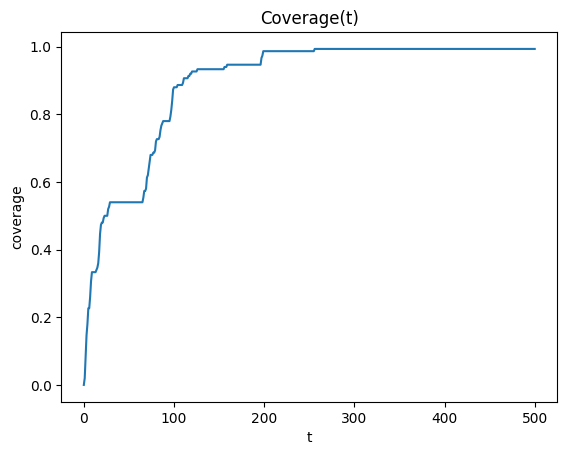

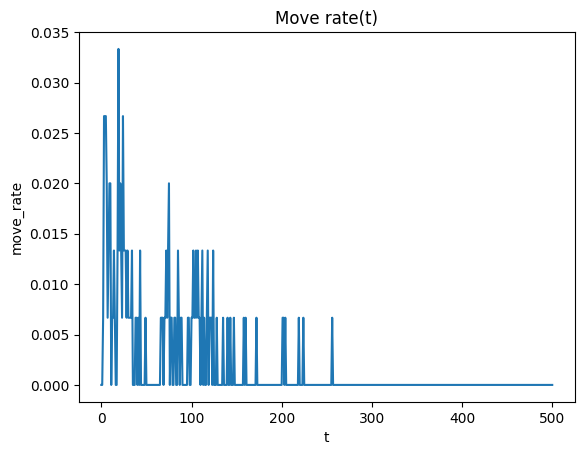

In [83]:
# Cargar dataset IRIS
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Definir seeds para robustez
seeds = list(range(30))

# Definir grid de hiperparámetros
param_grid = {
    "grid_scale": [4.0],
    "beacon_radius": [6, 8, 12],
    "local_beacon_cap": [3, 5, 8],
    "n_marker_agents": [3, 10, 20],
    "n_transporter_agents": [3, 10, 20],
    "tau_percentile": [15, 25],
    "iterations": [2500],
}
# Expandir combinaciones del grid
configs = expand_param_grid(param_grid)

# Ejecutar grid search y construir leaderboard
df_lb = build_leaderboard(X_iris, y_iris, configs, seeds, dataset_name="iris")
# Ordenar por criterio cerrado de selección
df_lb = df_lb.sort_values(
    ["ari_mean", "nmi_mean", "silhouette_mean", "davies_bouldin_mean"],
    ascending=[False, False, False, True]
)

# Guardar resultados para el paper
df_lb.to_csv("leaderboard_iris.csv", index=False)

# Filtrar configuraciones inviables
df_ok = filter_viable(df_lb, min_coverage=0.90, max_ari_std=0.10)

# Seleccionar top 10 configuraciones
df_top = select_top_configs(df_ok, top_k=10)
df_top.to_csv("leaderboard_iris_top10.csv", index=False)
display(df_top)
# Extraer mejor configuración
best_params = eval(df_top.iloc[0]["params"])

# Ejecutar run representativo con métricas online
out, seed_rep, metrics_rep, online_log = run_config_with_online(
    X_iris, y_iris, best_params, seeds, record_every=5
)
# Mostrar resultados finales
print("Los mejores resultados corresponden a: ", seed_rep)
display(metrics_rep)
# Visualizar métricas online
plot_online_curves(online_log)

## 4.2. Visualización animada del proceso (Iris)

Animación del proceso de clustering usando la mejor configuración encontrada y la semilla representativa.

Permite observar la dinámica espacial del algoritmo: exploración inicial, etiquetado, transporte y convergencia.

In [ ]:
# Permitir animaciones grandes
mpl.rcParams["animation.embed_limit"] = 300  # MB

# Mejor configuración
best_params = eval(df_top.iloc[0]["params"])
seed = seed_rep

# Separar parámetros de init y fit
iterations = best_params["iterations"]
init_params = {k: v for k, v in best_params.items() if k != "iterations"}

# Ejecutar solo para visualización
oic = OICGrid(
    **init_params,
    seed_object_placement=seed,
    seed_agent_walk=seed,
    seed_tau_calculator=seed,
)

oic.fit(
    X_iris,
    iterations=iterations,
    record_states=True,
    record_every=1,
)

# Animación
animate(oic.states)



## 4.3. Dataset Wine

Aplicación del mismo pipeline sobre Wine (178 instancias, 13 features, 3 clases).

Mayor dimensionalidad que Iris permite evaluar robustez del algoritmo en espacios de características más complejos.

TOP 10 EJECUCIONES


,params,ari_mean,ari_std,ari_median,nmi_mean,nmi_std,nmi_median,silhouette_mean,silhouette_std,silhouette_median,davies_bouldin_mean,davies_bouldin_std,davies_bouldin_median,coverage_mean,coverage_std,coverage_median,n_runs_ok,dataset,config_id
131,"{'grid_scale': 4.0, 'beacon_radius': 12, 'loca...",0.296997,0.067165,0.282726,0.488585,0.043795,0.487909,-0.514584,0.074787,-0.525400,13.987939,5.282520,11.971034,0.996442,0.006723,1.0,30,wine,131
129,"{'grid_scale': 4.0, 'beacon_radius': 12, 'loca...",0.293195,0.069607,0.277261,0.488801,0.042711,0.490521,-0.516748,0.061246,-0.516403,12.999482,4.030483,13.106841,0.993446,0.012981,1.0,30,wine,129
145,"{'grid_scale': 4.0, 'beacon_radius': 12, 'loca...",0.292759,0.076640,0.274830,0.503451,0.038607,0.500303,-0.588431,0.051518,-0.590514,12.085775,6.147899,11.667671,0.997378,0.005754,1.0,30,wine,145
127,"{'grid_scale': 4.0, 'beacon_radius': 12, 'loca...",0.288591,0.071355,0.276450,0.487234,0.041018,0.482059,-0.511958,0.067274,-0.514150,12.358030,4.348641,11.544872,0.997378,0.008425,1.0,30,wine,127
133,"{'grid_scale': 4.0, 'beacon_radius': 12, 'loca...",0.287948,0.055419,0.279520,0.487753,0.030738,0.494232,-0.503648,0.061788,-0.499081,11.502356,3.646319,11.323459,1.000000,0.000000,1.0,30,wine,133
126,"{'grid_scale': 4.0, 'beacon_radius': 12, 'loca...",0.287128,0.057887,0.286853,0.488586,0.033141,0.492493,-0.527966,0.065001,-0.536492,14.292292,4.848906,13.648834,0.996816,0.005166,1.0,30,wine,126
137,"{'grid_scale': 4.0, 'beacon_radius': 12, 'loca...",0.286836,0.064151,0.287345,0.488388,0.040465,0.491876,-0.512926,0.062968,-0.513576,13.689147,8.580822,12.234074,1.000000,0.000000,1.0,30,wine,137
143,"{'grid_scale': 4.0, 'beacon_radius': 12, 'loca...",0.286508,0.047895,0.278901,0.489911,0.031767,0.489034,-0.500182,0.058538,-0.507134,13.545168,5.502890,11.747853,1.000000,0.000000,1.0,30,wine,143
135,"{'grid_scale': 4.0, 'beacon_radius': 12, 'loca...",0.286253,0.052805,0.281712,0.487549,0.029082,0.490281,-0.507280,0.075153,-0.517023,12.856665,4.332791,11.335768,1.000000,0.000000,1.0,30,wine,135
139,"{'grid_scale': 4.0, 'beacon_radius': 12, 'loca...",0.285576,0.048588,0.281451,0.489094,0.029390,0.495159,-0.483486,0.067219,-0.482454,13.305694,5.069212,12.149614,1.000000,0.000000,1.0,30,wine,139


Los mejores resultados corresponden a:  15


{'coverage_final': 0.9943820224719101,
 'n_assigned': 177,
 'silhouette': -0.4789165621115645,
 'davies_bouldin': 8.528556439647922,
 'ari': 0.28389378806333737,
 'nmi': 0.48866257647614586}

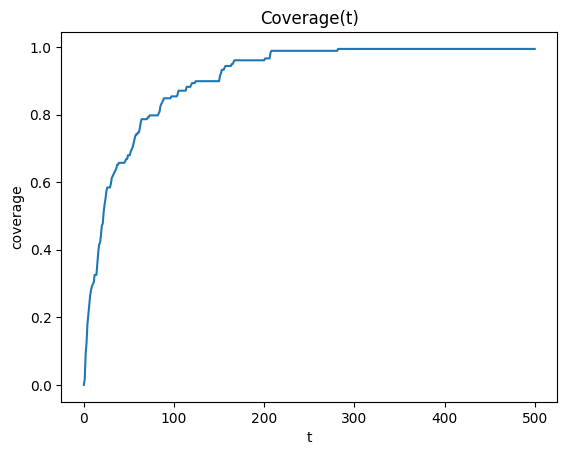

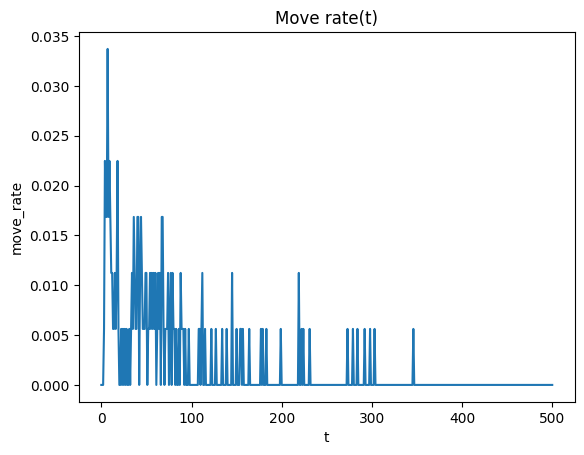

In [85]:
# Cargar dataset WINE
wine = load_wine()
X_wine = wine.data
y_wine = wine.target

# Reutilizar seeds
seeds = list(range(30))

# Reutilizar mismo grid de parámetros
configs = expand_param_grid(param_grid)

# Ejecutar grid search
df_lb_wine = build_leaderboard(X_wine, y_wine, configs, seeds, dataset_name="wine")

# Ordenar por criterio cerrado
df_lb_wine = df_lb_wine.sort_values(
    ["ari_mean", "nmi_mean", "silhouette_mean", "davies_bouldin_mean"],
    ascending=[False, False, False, True]
)

# Guardar resultados
df_lb_wine.to_csv("leaderboard_wine.csv", index=False)

# Filtrar configuraciones inviables
df_ok_wine = filter_viable(df_lb_wine, min_coverage=0.90, max_ari_std=0.10)

# Seleccionar top 10
df_top_wine = select_top_configs(df_ok_wine, top_k=10)
df_top_wine.to_csv("leaderboard_wine_top10.csv", index=False)
print("TOP 10 EJECUCIONES")
display(df_top_wine)

# Extraer mejor configuración
best_params_wine = eval(df_top_wine.iloc[0]["params"])

# Ejecutar run representativo con métricas online
out_w, seed_rep_w, metrics_rep_w, online_log_w = run_config_with_online(
    X_wine, y_wine, best_params_wine, seeds, record_every=5
)

# Mostrar resultados finales
print("Los mejores resultados corresponden a: ", seed_rep_w)
display(metrics_rep_w)

# Visualizar métricas online
plot_online_curves(online_log_w)

## 4.4. Visualización animada del proceso (Wine)

Animación equivalente usando la mejor configuración para Wine.

Permite comparar visualmente el comportamiento del algoritmo en datasets de distinta complejidad dimensional.

In [ ]:
# Permitir animaciones grandes
mpl.rcParams["animation.embed_limit"] = 300  # MB

# Mejor configuración para WINE
best_params_wine = eval(df_top_wine.iloc[0]["params"])
seed = seed_rep_w

# Separar parámetros de init y fit
iterations = best_params_wine["iterations"]
init_params = {k: v for k, v in best_params_wine.items() if k != "iterations"}

# Ejecutar solo para visualización
oic_wine = OICGrid(
    **init_params,
    seed_object_placement=seed,
    seed_agent_walk=seed,
    seed_tau_calculator=seed,
)

oic_wine.fit(
    X_wine,
    iterations=iterations,
    record_states=True,
    record_every=1,
)

# Animación
animate(oic_wine.states)


## 4.5. Comparación con K-means baseline

Evaluación comparativa con K-means para validar el rendimiento de OIC-Grid frente a un algoritmo de referencia establecido.

**Configuración del baseline**:
- K-means con K=3 (número de clases conocidas)
- 30 inicializaciones aleatorias por run (n_init=30)
- Inicialización k-means++
- Máximo 300 iteraciones
- Normalización z-score de los datos
- Mismas 30 semillas que OIC-Grid

**Nota**: K-means asigna todos los objetos (coverage=100%), mientras que OIC-Grid puede dejar objetos sin asignar basándose en criterios de similaridad. Esta diferencia se refleja en las métricas de coverage.

In [87]:
def eval_kmeans_summary(
    X,
    y_true,
    k: int,
    seeds=range(30),
    dataset_name: str = "",
):
    """Evalúa K-Means en múltiples seeds y devuelve métricas agregadas."""
    
    # Normalización z-score
    Xn = StandardScaler().fit_transform(X)

    ari, nmi, sil, db = [], [], [], []

    for seed in seeds:
        km = KMeans(
            n_clusters=k,
            init="k-means++",
            n_init=30,
            max_iter=300,
            random_state=seed,
        )

        y_pred = km.fit_predict(Xn)

        ari.append(adjusted_rand_score(y_true, y_pred))
        nmi.append(normalized_mutual_info_score(y_true, y_pred))
        sil.append(silhouette_score(Xn, y_pred))
        db.append(davies_bouldin_score(Xn, y_pred))

    summary = {
        "dataset": dataset_name,
        "algorithm": "kmeans",
        "k": k,

        "ari_mean": np.mean(ari),
        "ari_std": np.std(ari, ddof=1),

        "nmi_mean": np.mean(nmi),
        "nmi_std": np.std(nmi, ddof=1),

        "silhouette_mean": np.mean(sil),
        "silhouette_std": np.std(sil, ddof=1),

        "davies_bouldin_mean": np.mean(db),
        "davies_bouldin_std": np.std(db, ddof=1),

        "n_runs": len(seeds),
    }

    return pd.DataFrame([summary])


In [88]:
iris = load_iris()

df_kmeans_iris = eval_kmeans_summary(
    iris.data,
    iris.target,
    k=3,
    seeds=range(30),
    dataset_name="iris",
)

display(df_kmeans_iris)
df_kmeans_iris.to_csv("kmeans_iris_summary.csv", index=False)


,dataset,algorithm,k,ari_mean,ari_std,nmi_mean,nmi_std,silhouette_mean,silhouette_std,davies_bouldin_mean,davies_bouldin_std,n_runs
0,iris,kmeans,3,0.620135,2.258405e-16,0.659487,1.129203e-16,0.459948,5.646013e-17,0.833595,2.258405e-16,30


In [89]:
wine = load_wine()

df_kmeans_wine = eval_kmeans_summary(
    wine.data,
    wine.target,
    k=3,
    seeds=range(30),
    dataset_name="wine",
)

display(df_kmeans_wine)
df_kmeans_wine.to_csv("kmeans_wine_summary.csv", index=False)

,dataset,algorithm,k,ari_mean,ari_std,nmi_mean,nmi_std,silhouette_mean,silhouette_std,davies_bouldin_mean,davies_bouldin_std,n_runs
0,wine,kmeans,3,0.897495,1.129203e-16,0.875894,3.387608e-16,0.284859,1.129203e-16,1.389188,2.258405e-16,30


## 4.6. Análisis comparativo de resultados y conclusiones

Se compara el algoritmo propuesto **OIC-Grid** con **K-means** como baseline, utilizando los datasets **Iris** y **Wine**, y evaluando mediante métricas externas (ARI, NMI), internas (Silhouette, Davies–Bouldin) y cobertura final.

### Resultados cuantitativos

**Iris**

| Métrica | OIC-Grid | K-means |
|--------|----------|---------|
| ARI | 0.281 ± 0.051 | 0.620 ± 0.000 |
| NMI | 0.453 ± 0.033 | 0.660 ± 0.000 |
| Silhouette | -0.140 ± 0.049 | 0.460 ± 0.000 |
| Davies–Bouldin | 3.65 ± 1.05 | 0.83 ± 0.000 |
| Coverage | 99.9% | 100% |

**Wine**

| Métrica | OIC-Grid | K-means |
|--------|----------|---------|
| ARI | 0.297 ± 0.067 | 0.898 ± 0.000 |
| NMI | 0.489 ± 0.044 | 0.876 ± 0.000 |
| Silhouette | -0.515 ± 0.075 | 0.285 ± 0.000 |
| Davies–Bouldin | 13.99 ± 5.28 | 1.39 ± 0.000 |
| Coverage | 99.6% | 100% |

En ambos datasets, **K-means supera claramente a OIC-Grid** en todas las métricas de calidad de clustering, especialmente en Wine, donde la mayor dimensionalidad amplifica las limitaciones del enfoque basado en grid 2D.

### Interpretación

La brecha observada se explica principalmente por:

1. **Ventaja estructural del baseline**: K-means conoce el número de clusters a priori, mientras que OIC-Grid lo descubre de forma autónoma.
2. **Optimización explícita vs reglas locales**: K-means minimiza directamente la varianza intra-cluster; OIC-Grid se basa en decisiones estigmérgicas locales.
3. **Dependencia del grid 2D**: la organización espacial introduce distorsiones en la preservación de distancias semánticas, especialmente en espacios de alta dimensión.
4. **Sensibilidad al umbral τ**: valores conservadores fragmentan clusters naturales; el percentil 25 mejora resultados frente a 15, pero no elimina el solapamiento.

### Observaciones clave sobre OIC-Grid

**Fortalezas**:
- No requiere conocer K a priori.
- Alta cobertura (>99%) y estabilidad entre seeds.
- Proceso transparente y trazable mediante dinámica del grid.
- Métricas online permiten analizar convergencia y comportamiento dinámico.

**Limitaciones**:
- Rendimiento cuantitativo inferior a K-means.
- Silhouette negativo y Davies–Bouldin elevado indican solapamiento y baja separación.
- El grid 2D actúa como cuello de botella semántico.

### Conclusión

OIC-Grid no compite con K-means en rendimiento puro, pero valida una **propuesta descentralizada y explicable de clustering**, adecuada para escenarios donde **K es desconocido**, se prioriza **observabilidad del proceso** o se requiere **integración en sistemas multiagente o robóticos**. Su principal valor reside en el diseño y la dinámica del algoritmo, más que en la optimización directa de métricas estándar.
